Saving LIMFADD.csv to LIMFADD (2).csv
   Followers  Following  Following/Followers  Posts  Posts/Followers  Bio  \
0          2       2757          1378.500000      0         0.000000    0   
1          2        505           252.500000      0         0.000000    0   
2       6786       1782             0.262599   1589      6051.040404    1   
3         21       1281            61.000000      0         0.000000    0   
4        585       1682             2.875214   2663       926.192033    1   

   Profile Picture  External Link  Mutual Friends  Threads Labels  \
0                0              0               0        0    Bot   
1                1              0               0        0   Scam   
2                0              1              10        0   Real   
3                1              0               0        0    Bot   
4                0              0              12        1   Real   

   Labels_encoded  
0               0  
1               2  
2               1  
3   

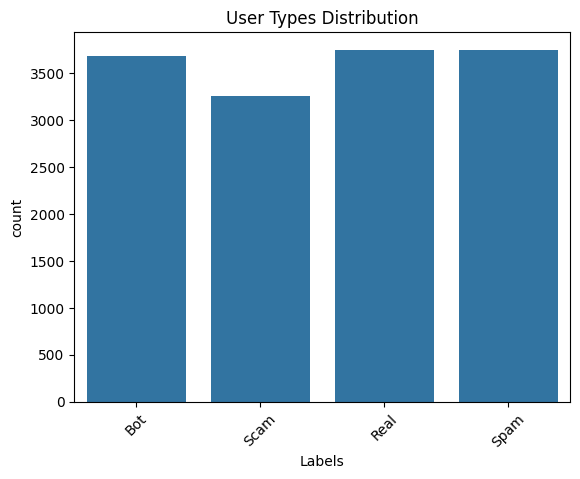

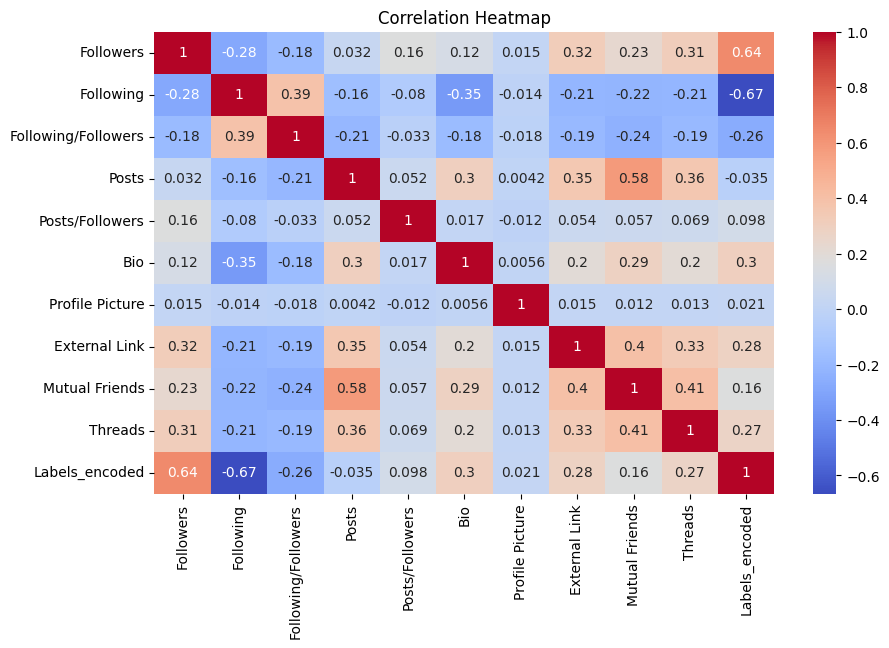


Cross-Validation: Logistic Regression
Scores: [0.94215449 0.94388639 0.93972982 0.94700381 0.94282744]
Mean Accuracy: 0.9431 | Std Dev: 0.0024

Cross-Validation: Random Forest
Scores: [0.96882577 0.97332871 0.97298233 0.97679252 0.97505198]
Mean Accuracy: 0.9734 | Std Dev: 0.0027

Evaluation: Logistic Regression
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       736
           1       0.93      0.95      0.94       750
           2       0.91      0.99      0.95       652
           3       0.96      0.92      0.94       749

    accuracy                           0.94      2887
   macro avg       0.95      0.95      0.95      2887
weighted avg       0.95      0.94      0.94      2887

Confusion Matrix:
 [[678   0  58   0]
 [  5 713   3  29]
 [  5   0 647   0]
 [  0  57   2 690]]

Evaluation: Random Forest
Classification Report:
               precision    recall  f1-score   support

           0       1.00 

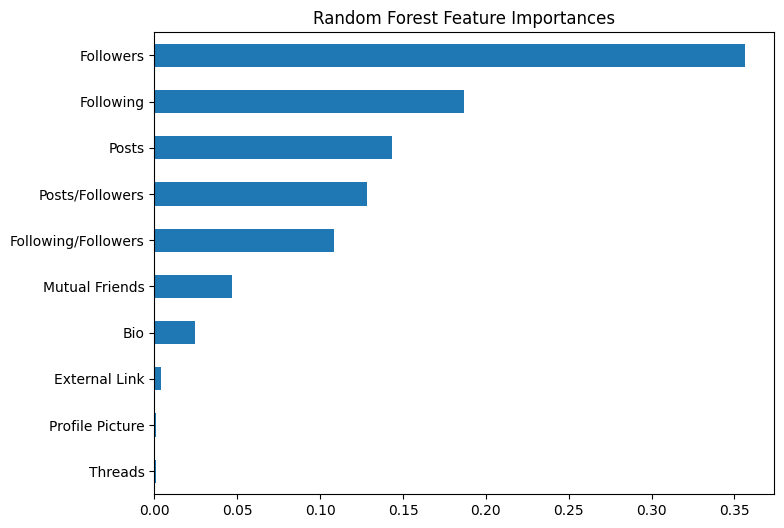


Running Isolation Forest Anomaly Detection...


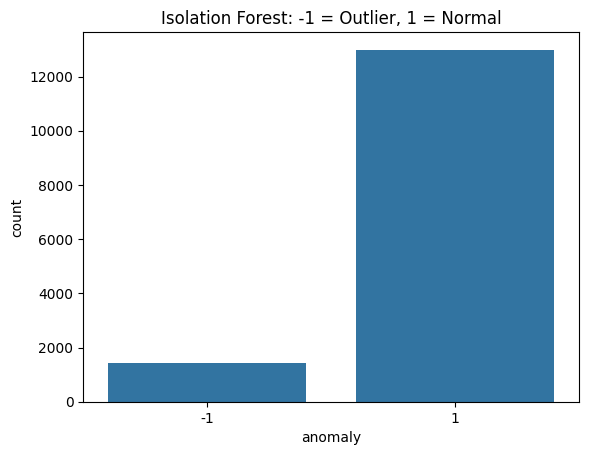

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
uploaded = files.upload()
df = pd.read_csv("LIMFADD.csv")

# Data Cleaning
df['Following/Followers'] = pd.to_numeric(df['Following/Followers'], errors='coerce')
df['Posts/Followers'] = pd.to_numeric(df['Posts/Followers'], errors='coerce')
binary_cols = ['Bio', 'Profile Picture', 'External Link', 'Threads']
for col in binary_cols:
    df[col] = df[col].str.strip().str.lower().map({'yes': 1, 'n': 0, 'no': 0})
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Label Encoding
le = LabelEncoder()
df['Labels_encoded'] = le.fit_transform(df['Labels'])

# Data Preview
print(df.head())

# Class Distribution
sns.countplot(x='Labels', data=df)
plt.title("User Types Distribution")
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Split Data
X = df.drop(['Labels', 'Labels_encoded'], axis=1)
y = df['Labels_encoded']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression - Cross Validation
print("\nCross-Validation: Logistic Regression")
lr = LogisticRegression(max_iter=5000, solver='liblinear', class_weight='balanced')
lr_scores = cross_val_score(lr, X_scaled, y, cv=cv, scoring='accuracy')
print("Scores:", lr_scores)
print(f"Mean Accuracy: {lr_scores.mean():.4f} | Std Dev: {lr_scores.std():.4f}")

# Random Forest - Cross Validation
print("\nCross-Validation: Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("Scores:", rf_scores)
print(f"Mean Accuracy: {rf_scores.mean():.4f} | Std Dev: {rf_scores.std():.4f}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression - Confusion Matrix
print("\nEvaluation: Logistic Regression")
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Random Forest - Confusion Matrix
print("\nEvaluation: Random Forest")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Feature Importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title="Random Forest Feature Importances")
plt.show()

# Anomaly Detection - Isolation Forest
print("\nRunning Isolation Forest Anomaly Detection...")
iso = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = iso.fit_predict(X)
sns.countplot(x='anomaly', data=df)
plt.title('Isolation Forest: -1 = Outlier, 1 = Normal')
plt.show()